In [1]:
import numpy as np
import time
from selenium import webdriver

import base64
import cv2 as cv

from gymnasium import Env
from gymnasium.spaces import Box, Discrete



In [51]:
class Dino(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low= 0, high=255, shape=(1, 220, 300), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.game_over = cv.imread("dark_game_over.jpg")
        self.init_dino()

    def init_dino(self):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--mute-audio")
        chrome = webdriver.Chrome(options=chrome_options)
        # To avoid an exception while opening a URL without a connection
        try:
            chrome.get("chrome://dino")
        except:
            pass

        chrome.set_window_size(800, 600)
        self.chrome = chrome
        # Load the game
        time.sleep(1)
        self.send_key(webdriver.Keys.SPACE)
        time.sleep(2)
        self.chrome.execute_script("Runner.instance_.gameOver()")
    
    def step(self, action):
        action_map = {0: webdriver.Keys.SPACE, 1: webdriver.Keys.ARROW_DOWN, 2: "no_op"}
        reward = 2
        if action != 2:
            self.send_key(action_map[action])
            reward = 1
        

        self.set_last_record()
        done, _ = self.get_done()

        print(done, self.get_game_over_simmilarity(self.last_record[165:190,320:665]))
        plt.imshow(self.last_record[165:190,320:665])
        plt.show()
        observation = self.get_observation()
        info = {}
        return observation, reward, done, False, info
    
    def set_last_record(self):

        b64_image = self.chrome.get_screenshot_as_base64()
        b64_decoded = np.frombuffer(base64.b64decode(b64_image), np.uint8)
        self.last_record = cv.imdecode(b64_decoded, cv.IMREAD_COLOR)

    def get_last_record(self):
        return self.last_record

    def get_observation(self):
        observation = self.last_record[100:320, 50:350]
        observation = np.reshape(observation, (1, 220, 300))

        return observation
    
    def get_done(self):
        done = False
        done_record = self.last_record[165:190,320:665]
        similarity = self.get_game_over_simmilarity(done_record)
        # In dark mode there is a 100% similarity but in light mode there is a 55% similarity. I take an error margin of 10%
        if similarity >= 90 or 50 <= similarity <= 60:
            done = True

        return done, done_record
    
    def close(self):
        self.chrome.quit()

    def reset(self,seed=None):
        time.sleep(2)
        self.send_key(webdriver.Keys.SPACE)
        self.set_last_record()
        info = {}
        return (self.get_observation(), info)

    def get_game_over_simmilarity(self, image):
        difference = np.sum(np.abs(self.game_over - image))
        pixels = image.size
        similarity = (100 - (difference / pixels))

        return similarity
    
    def send_key(self, key):
        webdriver.ActionChains(self.chrome).send_keys(key).perform()


In [73]:
cv.imdecode(b64_decoded, cv.IMREAD_GRAYSCALE)



NameError: name 'b64_decoded' is not defined

In [84]:
a = env.last_record

observation = np.moveaxis(a, -1, 0)  # Adjust axis to (channels, height, width)
observation = np.expand_dims(observation, axis=0)  # Add an extra dimension for batch


In [88]:
a.shape

(580, 984, 3)

In [71]:
cv.imshow("a",env.last_record)
cv.waitKey(0)
cv.destroyAllWindows()

97

In [3]:
env = Dino()

TypeError: Invalid shape (1, 25, 345) for image data

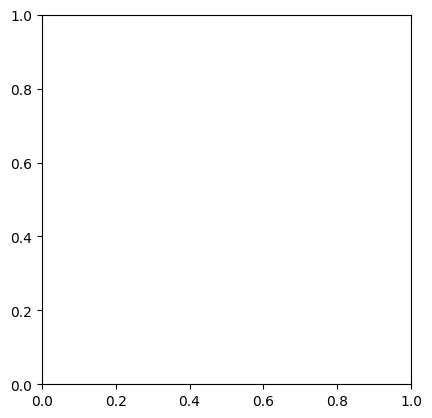

In [7]:
plt.imshow(env.game_over)
plt.show()

In [10]:
env = Dino()

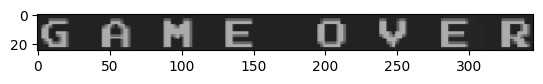

In [47]:
plt.imshow(cv.imread("dark_game_over.jpg"))

In [5]:
from matplotlib import pyplot as plt

In [16]:
cv.imshow("A",env.get_done()[1])
cv.waitKey(0)

-1

In [37]:
cv.destroyAllWindows()

In [2]:

driver = webdriver.Chrome()
driver.get("chrome://dino")

WebDriverException: Message: unknown error: net::ERR_INTERNET_DISCONNECTED
  (Session info: chrome=120.0.6099.130)
Stacktrace:
	GetHandleVerifier [0x00007FF7BB4F2142+3514994]
	(No symbol) [0x00007FF7BB110CE2]
	(No symbol) [0x00007FF7BAFB76AA]
	(No symbol) [0x00007FF7BAFAFB39]
	(No symbol) [0x00007FF7BAFA25DD]
	(No symbol) [0x00007FF7BAFA16FD]
	(No symbol) [0x00007FF7BAFA0746]
	(No symbol) [0x00007FF7BAFA06EB]
	(No symbol) [0x00007FF7BAF9EE3D]
	(No symbol) [0x00007FF7BAF9F603]
	(No symbol) [0x00007FF7BAFBA0FD]
	(No symbol) [0x00007FF7BB042E01]
	(No symbol) [0x00007FF7BB025FEA]
	(No symbol) [0x00007FF7BB0428F6]
	(No symbol) [0x00007FF7BB025D93]
	(No symbol) [0x00007FF7BAFF4BDC]
	(No symbol) [0x00007FF7BAFF5C64]
	GetHandleVerifier [0x00007FF7BB51E16B+3695259]
	GetHandleVerifier [0x00007FF7BB576737+4057191]
	GetHandleVerifier [0x00007FF7BB56E4E3+4023827]
	GetHandleVerifier [0x00007FF7BB2404F9+689705]
	(No symbol) [0x00007FF7BB11C048]
	(No symbol) [0x00007FF7BB118044]
	(No symbol) [0x00007FF7BB1181C9]
	(No symbol) [0x00007FF7BB1088C4]
	BaseThreadInitThunk [0x00007FFC3C0F257D+29]
	RtlUserThreadStart [0x00007FFC3D48AA58+40]


In [4]:
driver.execute_script("Runner.instance_.distanceRan * Runner.instance_.distanceMeter.config.COEFFICIENT")

In [83]:
driver.get_log()

In [28]:
env.close()

In [52]:
env = Dino()
for episode in range(1): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, _, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 
   

ValueError: cannot reshape array of size 198000 into shape (1,220,300)

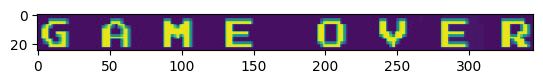

In [34]:
plt.imshow(env.game_over)
plt.show()

In [31]:
env.close()

In [3]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [12]:
env = Dino()
env_checker.check_env(env)
env.close()

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [12]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [13]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [14]:
env = Dino()
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size= 10000 , learning_starts=1000)
model.learn(total_timesteps=100000, callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | 20.2     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4        |
|    time_elapsed     | 23       |
|    total_timesteps  | 118      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 58       |
|    ep_rew_mean      | 38.8     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 67       |
|    total_timesteps  | 464      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.5     |
|    ep

KeyboardInterrupt: 

In [16]:
model.load('train/best_model_16000') 


In [20]:
for episode in range(5): 
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done,_ ,info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 565.0
Total Reward for episode 1 is 3.5
Total Reward for episode 2 is 0.5
Total Reward for episode 3 is 1


KeyboardInterrupt: 